# Affective Experience Predicts Engagement during Naturalistic Viewing

JIN KE

## Short intro of the background of the project: 

People’s attention fluctuates overtime. When comprehending naturalistic stimuli (e.g., listening to a story, watching a video), attention is captured by the content of the stimuli in which emotional arousal plays an important role. Narrative engagement has been defined as the experience of being deeply immersed in a story and connecting to its plots and characters (Bilandzic et al., 2019), and emotional engagement is believed to be a key dimension of it (Russelle & Helena, 2009). Prior literature revealed that people are more engaged during emotional moments in naturalistic viewing (Song, Finn, & Rosenberg, 2021), and cortical regions (e.g., ventromedial prefrontal cortex) reflect affective experience in this process (Chang et al., 2021). **In this study, we are interested in which kind of emotions are predictive of narrative engagement which we hope can give us a general sense of the role of valence and arousal in emotional engagement through this exploratory project**.

To do this, I used the Friday Night Lights dataset (Chang et al., 2021), calculated dynamic functional connectivity and applied a vector regression model (Song, Finn, & Rosenberg, 2021) to predict moment-by-moment engagement from fMRI measures. I then built several regression models (linear regression, ridge regression, and linear regression) to predict narrative engagement (predicted from brain data) from sixteen types of emotions, the results of which shows that both arousal and valence matter for emotions to be predictive of engagement.

## About this code:

The first part of code trains a **support vector regression model** to predict moment-by-moment behavioral data (group-average engagement) from moment-by-moment fMRI measures (dynamic functional connectivity) in all participants from one dataset (*Sherlock*). The trained SVR is applied to every subject in the test dataset (*Friday Night Lights*) to predict behavior from time-resolved functional connectivity (generated in the matlab code). 

The second part of code trains **linear regression models, ridge regression models, and lasso regression models** to predict engagement from emotions.

## Import libraries

In [2]:
import numpy as np
import os
from sklearn import svm
from sklearn import metrics
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats, linalg
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
def conv_r2z(r):
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
def conv_z2r(z):
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
%matplotlib inline

## Settings

In [3]:
dataset_learn = 'sherlock'
dataset_new = "FNL"
thres = 0.01
nR = 122
path = '/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/fMRI/'
path2 = '/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/fMRI/data/data_processed/FNL/win30'

learn_nsubj = scipy.io.loadmat(path + 'sherlock/hyperparameters.mat')[dataset_learn + '_nsubj'][0][0]
learn_wsize = scipy.io.loadmat(path + 'sherlock/hyperparameters.mat')[dataset_learn + '_wsize'][0]
learn_nT = scipy.io.loadmat(path + 'sherlock/hyperparameters.mat')[dataset_learn + '_nT'][0][0]

testNew_nsubj = 34
testNew_wsize = 30
testNew_nT = 1364


print('Across-dataset prediction')

learn_wsize = learn_wsize[1]
print('  model learn from = '+str(dataset_learn)+' win'+str(learn_wsize))
print('  model testing_New = '+str(dataset_new)+' win'+str(testNew_wsize))

Across-dataset prediction
  model learn from = sherlock win30
  model testing_New = FNL win30


## Load behavior data

In [4]:
engagement_learn = scipy.io.loadmat(path + '/behavior/'+ dataset_learn + '/win' + str(learn_wsize) + '/sliding-engagement.mat')['sliding_engagement'][:,0]
print('  model learn: engagement shape '+str(engagement_learn.shape))

  model learn: engagement shape (1946,)


## Load brain data

In [5]:
dynFeat_learn = scipy.io.loadmat(path + '/behavior/' + dataset_learn + '/win'+str(learn_wsize) + '/sliding-dynFeat.mat')['dynFeat']
dynFeat_learn = scipy.stats.zscore(dynFeat_learn,2,nan_policy='omit') # zscore per feature
print('  model learn: brain entire feature shape '+str(dynFeat_learn.shape))

  model learn: brain entire feature shape (17, 7381, 1946)


In [6]:
# load new data
import mat73
dynFeat_testNew = mat73.loadmat(path2 + '/sliding-dynFeat.mat')['dynFeat']
dynFeat_testNew = scipy.stats.zscore(dynFeat_testNew,2,nan_policy='omit') # zscore per feature

In [7]:
print('  model test : brain entire feature shape '+str(dynFeat_testNew.shape))

  model test : brain entire feature shape (34, 7381, 1334)


## Load brain features
In a within-dataset prediction, we conducted feature selection in each cross-validation (functional connections that were significantly correlated with group-average engagement with the training sample). Here, we use functional connections that were selected in *every* round of cross-validation. (The code runs with the saved output from within-dataset prediction.)

In [8]:
savepath=path+'/brain_features/dynPred/'+str(dataset_learn)+'/win' +str(learn_wsize)
pos_feat = scipy.io.loadmat(savepath + '/within_engagement.mat')['pos_feat']
neg_feat = scipy.io.loadmat(savepath + '/within_engagement.mat')['neg_feat']
pos_feat, neg_feat = np.average(pos_feat,0), np.average(neg_feat,0)
for i1 in range(nR):
    for i2 in range(nR):
        if pos_feat[i1,i2]<1:
            pos_feat[i1,i2]=0
        if neg_feat[i1,i2]<1:
            neg_feat[i1,i2]=0
print(' #pos = '+str(int(np.sum(pos_feat)/2)), ', #neg = '+str(int(np.sum(neg_feat)/2)))
all_feat = pos_feat+neg_feat
featid = []
ii = -1
for i1 in range(nR-1):
    for i2 in range(i1+1,nR):
        ii=ii+1
        if all_feat[i1,i2]==1:
            featid.append(ii)

 #pos = 583 , #neg = 102


In [9]:
dynFeat_learn = dynFeat_learn[:,featid,:]
dynFeat_testNew = dynFeat_testNew[:,featid,:]
print('  model learn: brain selected feature shape '+str(dynFeat_learn.shape))
print('  model test : brain selected feature shape '+str(dynFeat_testNew.shape))

  model learn: brain selected feature shape (17, 685, 1946)
  model test : brain selected feature shape (34, 685, 1334)


In [10]:
train_feat = np.transpose(dynFeat_learn,(1,0,2))
train_feat = np.reshape(train_feat,(train_feat.shape[0],train_feat.shape[1]*train_feat.shape[2]))

train_engagement = []
for sub in range(learn_nsubj):
    train_engagement.append(engagement_learn)
train_engagement = np.asarray(train_engagement)
train_engagement = np.reshape(train_engagement, (train_engagement.shape[0] * train_engagement.shape[1]))

# if several TRs are removed
rmtr_train = []
for tm in range(train_feat.shape[1]):
    if np.all(np.isnan(train_feat[:,tm])):
        rmtr_train.append(tm)
rmtr_train = np.asarray(rmtr_train)
if len(rmtr_train)>0:
    train_feat = np.delete(train_feat,rmtr_train,1)
    train_engagement = np.delete(train_engagement,rmtr_train,0)

In [11]:
nanidx = []
for ft in range(train_feat.shape[0]):
    if np.any(np.isnan(train_feat[ft,:])):
        nanidx.append(ft)
for subj in range(dynFeat_testNew.shape[0]):
    for ft in range(dynFeat_testNew.shape[1]):
        if dataset_test=='sherlock' and subj==4:
            pass
        else:
            if np.any(np.isnan(dynFeat_testNew[subj,ft,:])):
                nanidx.append(ft)
nanidx = np.unique(nanidx)
print('NaN = '+str(nanidx))

if len(nanidx)>0:
    train_feat = np.delete(train_feat,nanidx,0)
    dynFeat_testNew = np.delete(dynFeat_testNew,nanidx,1)

NaN = []


In [12]:
train_feat.shape

(685, 33031)

In [13]:
dynFeat_testNew.shape

(34, 685, 1334)

## Support vector regression with non-linear kernel

In [14]:
print('SVR prediction with model learned from '+str(dataset_learn))
print('  train feature   : '+str(train_feat.T.shape))
print('  train engagement: '+str(train_engagement.shape))

clf = []
clf = svm.SVR(kernel='rbf',max_iter=1000, gamma='auto')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    clf.fit(train_feat.T, train_engagement)
print('Training done!')

SVR prediction with model learned from sherlock
  train feature   : (33031, 685)
  train engagement: (33031,)
Training done!


In [15]:
output_acc, output_eval = [], []
for test_sub in range(testNew_nsubj):
    testNew_feat = dynFeat_testNew[test_sub, :, :]
    #test_behavior = engagement_test

    rmtr_testNew = []
    for tm in range(testNew_feat.shape[1]):
        if np.all(np.isnan(testNew_feat[:, tm])):
            rmtr_testNew.append(tm)
    rmtr_testNew = np.asarray(rmtr_testNew)
    if len(rmtr_testNew) > 0:
        testNew_feat = np.delete(testNew_feat, rmtr_testNew, 1)
        #test_behavior = np.delete(test_behavior, rmtr_test, 0)

    predicted = clf.predict(testNew_feat.T)
    output_acc.append(predicted)

output_acc = np.asarray(output_acc)


In [16]:
testNew_feat.shape

(685, 1334)

In [17]:
output_acc.shape

(34, 1334)

## Read in emotion rating data

In [18]:
emotion_sum = np.empty(shape=(16,1334),dtype='float')

def tidying(emo_id):    
    import pandas as pd
    
    # load in data
    
    if emo_id == 1:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Anger_NNMF_SGD_Dilate60_v3.csv')
        print('reading anger data')
    elif emo_id == 2:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Contempt_NNMF_SGD_Dilate60_v3.csv')
        print('reading comtempt data')
    elif emo_id == 3:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Disgust_NNMF_SGD_Dilate60_v3.csv')
        print('reading disgust data')
    elif emo_id == 4:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Elation_NNMF_SGD_Dilate60_v3.csv')
        print('reading elation data')
    elif emo_id == 5:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Envy_NNMF_SGD_Dilate60_v3.csv')
        print('reading envy data')
    elif emo_id == 6:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Fear_NNMF_SGD_Dilate60_v3.csv')
        print('reading fear data')
    elif emo_id == 7:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Guilt_NNMF_SGD_Dilate60_v3.csv')
        print('reading guilt data')
    elif emo_id == 8:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Hope_NNMF_SGD_Dilate60_v3.csv')
        print('reading hope data')
    elif emo_id == 9:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Interest_NNMF_SGD_Dilate60_v3.csv')
        print('reading interest data')
    elif emo_id == 10:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Joy_NNMF_SGD_Dilate60_v3.csv')
        print('reading joy data')
    elif emo_id == 11:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Pride_NNMF_SGD_Dilate60_v3.csv')
        print('reading pride data')
    elif emo_id == 12:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Relief_NNMF_SGD_Dilate60_v3.csv')
        print('reading relief data')
    elif emo_id == 13:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Sadness_NNMF_SGD_Dilate60_v3.csv')
        print('reading sadness data')
    elif emo_id == 14:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Satisfaction_NNMF_SGD_Dilate60_v3.csv')
        print('reading satisfaction data')
    elif emo_id == 15:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Shame_NNMF_SGD_Dilate60_v3.csv')
        print('reading shame data')
    elif emo_id == 16:
        emotion_df = pd.read_csv('/Users/myelin/Desktop/jin/SANS_2022_DataCompetition/Study4_SubjectiveRatings/FNL_EmotionCF_Surprise_NNMF_SGD_Dilate60_v3.csv')
        print('reading surprise data')
        
    # preprocess
    emotion_df = emotion_df.iloc[:,1:]
    emotion_raw = np.array(emotion_df)

    emotion_shorter = np.empty(shape=(emotion_raw.shape[0],int(emotion_raw.shape[1]/2)),dtype='float')
    for i in range(0,int(emotion_raw.shape[0])):
        for j in range(0,int(emotion_raw.shape[1]/2)):
                emotion_shorter[i,j] = np.average(emotion_raw[i,j*2:j*2+2])
    #print('emotion_shorter is half the raw data in time points by averaging every two time points.')
    print('emotion_shorter size = ' + str(int(emotion_raw.shape[0]))+'*'+ str(int(emotion_raw.shape[1]/2)))

    win = 30
    emotion_sliding = np.empty(shape=(emotion_raw.shape[0],int(emotion_raw.shape[1]/2)-30),dtype='float') #192*1334

    for sub in range(0,int(emotion_shorter.shape[0])):
        for slid in range(0,emotion_shorter.shape[1]-win):
            emotion_sliding[sub,slid] = np.average(emotion_raw[sub,slid:slid+win])

    print('emotion_sliding size = ' + str(emotion_raw.shape[0])+'*'+ str(int(emotion_shorter.shape[1]-win)))
    #print('sliding window = '+str(win))
    #print('emotion_sliding is a result of averaging every window slide' )

    emotion = np.empty(shape=(1,int(emotion_raw.shape[1]/2)-30),dtype='float')
    for time_point in range(0,emotion_sliding.shape[1]):
        emotion[0,time_point]= np.average(emotion_sliding[0:emotion_sliding.shape[0],time_point])

    print('emotion size = ' + str(emotion.shape[0])+'*'+ str(int(emotion.shape[1])))
    
    for time_point in range(0,emotion_sliding.shape[1]):
        emotion_sum[emo_id-1,time_point] = emotion[0,time_point]
    
    return emotion_sum

In [19]:
tidying(1)

reading anger data
emotion_shorter size = 192*1364
emotion_sliding size = 192*1334
emotion size = 1*1334


array([[ 5.44658438,  5.38878926,  5.32070025, ...,  9.24619772,
         9.11327455,  8.97886388],
       [-0.06515629, -0.07994987, -0.09563478, ...,  0.70040404,
         0.68345891,  0.66284633],
       [ 0.63886346,  0.61185273,  0.58212699, ..., -2.12384439,
        -2.16794826, -2.21128339],
       ...,
       [-0.59732598, -0.59187265, -0.58526872, ...,  1.38799598,
         1.3993429 ,  1.41158044],
       [ 1.42479891,  1.43904461,  1.45430169, ..., -0.84863201,
        -0.85723487, -0.86574605],
       [-0.87416035, -0.88238926, -0.89027299, ...,  1.12127467,
         1.12716207,  1.13225016]])

In [20]:
for emo_id in range(1,17):
    tidying(emo_id)

reading anger data
emotion_shorter size = 192*1364
emotion_sliding size = 192*1334
emotion size = 1*1334
reading comtempt data
emotion_shorter size = 192*1364
emotion_sliding size = 192*1334
emotion size = 1*1334
reading disgust data
emotion_shorter size = 192*1364
emotion_sliding size = 192*1334
emotion size = 1*1334
reading elation data
emotion_shorter size = 192*1364
emotion_sliding size = 192*1334
emotion size = 1*1334
reading envy data
emotion_shorter size = 192*1364
emotion_sliding size = 192*1334
emotion size = 1*1334
reading fear data
emotion_shorter size = 192*1364
emotion_sliding size = 192*1334
emotion size = 1*1334
reading guilt data
emotion_shorter size = 192*1364
emotion_sliding size = 192*1334
emotion size = 1*1334
reading hope data
emotion_shorter size = 192*1364
emotion_sliding size = 192*1334
emotion size = 1*1334
reading interest data
emotion_shorter size = 192*1364
emotion_sliding size = 192*1334
emotion size = 1*1334
reading joy data
emotion_shorter size = 192*1364

In [21]:
emotion_sum

array([[ 5.44658438,  5.38878926,  5.32070025, ...,  9.24619772,
         9.11327455,  8.97886388],
       [ 5.59584803,  5.50141246,  5.40511309, ...,  9.51813228,
         9.39241512,  9.26693879],
       [ 4.44628982,  4.30934719,  4.19321923, ..., 11.88632064,
        11.82778481, 11.76873818],
       ...,
       [25.0282748 , 24.96747643, 24.89534322, ..., 25.77363933,
        25.86682223, 25.96114811],
       [ 3.33775911,  3.28513175,  3.23111882, ...,  5.30672698,
         5.2615896 ,  5.21825887],
       [13.05952982, 12.74337859, 12.42832816, ..., 16.71460716,
        16.646159  , 16.57693742]])

In [22]:
emotion_sum.shape

(16, 1334)

In [23]:
emotion_transpose = emotion_sum.transpose()
emotion_transpose.shape

(1334, 16)

In [24]:
# engagement data
output_acc.shape
engagement = np.empty(shape=(1,1334),dtype='object')

for time_point in range(0,output_acc.shape[1]):
    engagement[0,time_point] = np.average(output_acc[0:output_acc.shape[0],time_point])

engagement.shape

(1, 1334)

In [25]:
engagement

array([[-0.36733665256169706, -0.36817019350929037, -0.36465380592793517,
        ..., 0.04549946529163932, 0.04543062996775671,
        0.039122126492720455]], dtype=object)

In [137]:
# combine engagement data with emotion data

data = np.empty(shape=(17,1334),dtype='float')
for time_point in range(0,data.shape[1]):
    data[0,time_point] = engagement[0,time_point]
    for iv in range(1,17):
        data[iv,time_point] = emotion_sum[iv-1,time_point]
data.shape
data

array([[-0.36733665, -0.36817019, -0.36465381, ...,  0.04549947,
         0.04543063,  0.03912213],
       [ 5.44658438,  5.38878926,  5.32070025, ...,  9.24619772,
         9.11327455,  8.97886388],
       [ 5.59584803,  5.50141246,  5.40511309, ...,  9.51813228,
         9.39241512,  9.26693879],
       ...,
       [25.0282748 , 24.96747643, 24.89534322, ..., 25.77363933,
        25.86682223, 25.96114811],
       [ 3.33775911,  3.28513175,  3.23111882, ...,  5.30672698,
         5.2615896 ,  5.21825887],
       [13.05952982, 12.74337859, 12.42832816, ..., 16.71460716,
        16.646159  , 16.57693742]])

In [27]:
# transpose data
data_transpose = data.transpose()
data_transpose.shape

(1334, 17)

In [28]:
# converting data to dataframe
import pandas as pd
df = pd.DataFrame(data_transpose,columns = ['engagement','anger','content','disgust','elation','envy','fear','guilt','hope','interest','joy','pride','relief','sadness','satisfaction','shame','surprise'])

In [29]:
df

,engagement,anger,content,disgust,elation,envy,fear,guilt,hope,interest,joy,pride,relief,sadness,satisfaction,shame,surprise
0,-0.367337,5.446584,5.595848,4.446290,8.796342,4.713031,5.655838,3.361909,29.351874,62.922061,13.374680,12.792089,6.753319,11.407031,25.028275,3.337759,13.059530
1,-0.368170,5.388789,5.501412,4.309347,8.673969,4.604401,5.360028,3.330852,29.182048,62.925684,13.264334,12.597194,6.645313,11.167729,24.967476,3.285132,12.743379
2,-0.364654,5.320700,5.405113,4.193219,8.550274,4.488069,5.064130,3.294218,29.038065,62.939699,13.158339,12.476978,6.547280,10.925310,24.895343,3.231119,12.428328
3,-0.358004,5.252753,5.308887,4.077352,8.426256,4.371515,4.768290,3.257655,28.892655,62.953246,13.052987,12.355655,6.449254,10.683366,24.822593,3.177118,12.113452
4,-0.349648,5.208010,5.234728,3.988464,8.348220,4.266832,4.616437,3.226103,28.973023,63.098729,13.000195,12.302456,6.372666,10.505439,24.796182,3.131697,11.985595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,0.029039,9.513880,9.769076,12.005852,9.806960,7.987015,9.053846,4.035535,28.361346,60.105019,15.072875,15.910907,7.486780,8.815616,25.580701,5.394559,16.862858
1330,0.039256,9.378308,9.643195,11.945305,9.846851,7.933014,8.997537,4.017465,28.425540,60.118828,15.170983,16.040984,7.499902,8.752338,25.684237,5.349722,16.786140
1331,0.045499,9.246198,9.518132,11.886321,9.887981,7.874583,8.948423,4.000922,28.487327,60.133504,15.261111,16.169194,7.516236,8.690235,25.773639,5.306727,16.714607
1332,0.045431,9.113275,9.392415,11.827785,9.938752,7.820826,8.898041,3.981211,28.551271,60.146064,15.353441,16.305973,7.536250,8.628580,25.866822,5.261590,16.646159


Text(0.5, 1.0, 'Engagement histogram')

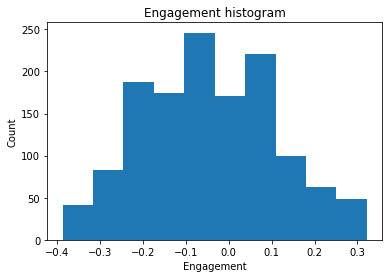

In [30]:
import matplotlib.pyplot as plt
plt.hist(df['engagement'])
plt.xlabel('Engagement')
plt.ylabel('Count')
plt.title('Engagement histogram')

Text(0.5, 1.0, 'Anger histogram')

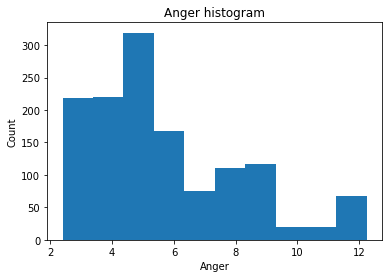

In [31]:
plt.hist(df['anger'])
plt.xlabel('Anger')
plt.ylabel('Count')
plt.title('Anger histogram')

## Building regression model

Tried linear regression model, Ridge regression model, and lasso regression model.

In [32]:
df.describe(include = 'all')['engagement']

count    1334.000000
mean       -0.044273
std         0.154948
min        -0.386910
25%        -0.163753
50%        -0.050975
75%         0.069730
max         0.322064
Name: engagement, dtype: float64

In [33]:
df.engagement.shape

(1334,)

In [34]:
df.describe(include = 'all')['anger']

count    1334.000000
mean        5.693904
std         2.462018
min         2.390614
25%         3.843766
50%         4.951345
75%         7.323218
max        12.248816
Name: anger, dtype: float64

In [35]:
# only the predictors
df_IV = df.iloc[:,1:]
df_IV

,anger,content,disgust,elation,envy,fear,guilt,hope,interest,joy,pride,relief,sadness,satisfaction,shame,surprise
0,5.446584,5.595848,4.446290,8.796342,4.713031,5.655838,3.361909,29.351874,62.922061,13.374680,12.792089,6.753319,11.407031,25.028275,3.337759,13.059530
1,5.388789,5.501412,4.309347,8.673969,4.604401,5.360028,3.330852,29.182048,62.925684,13.264334,12.597194,6.645313,11.167729,24.967476,3.285132,12.743379
2,5.320700,5.405113,4.193219,8.550274,4.488069,5.064130,3.294218,29.038065,62.939699,13.158339,12.476978,6.547280,10.925310,24.895343,3.231119,12.428328
3,5.252753,5.308887,4.077352,8.426256,4.371515,4.768290,3.257655,28.892655,62.953246,13.052987,12.355655,6.449254,10.683366,24.822593,3.177118,12.113452
4,5.208010,5.234728,3.988464,8.348220,4.266832,4.616437,3.226103,28.973023,63.098729,13.000195,12.302456,6.372666,10.505439,24.796182,3.131697,11.985595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,9.513880,9.769076,12.005852,9.806960,7.987015,9.053846,4.035535,28.361346,60.105019,15.072875,15.910907,7.486780,8.815616,25.580701,5.394559,16.862858
1330,9.378308,9.643195,11.945305,9.846851,7.933014,8.997537,4.017465,28.425540,60.118828,15.170983,16.040984,7.499902,8.752338,25.684237,5.349722,16.786140
1331,9.246198,9.518132,11.886321,9.887981,7.874583,8.948423,4.000922,28.487327,60.133504,15.261111,16.169194,7.516236,8.690235,25.773639,5.306727,16.714607
1332,9.113275,9.392415,11.827785,9.938752,7.820826,8.898041,3.981211,28.551271,60.146064,15.353441,16.305973,7.536250,8.628580,25.866822,5.261590,16.646159


In [36]:
df_IV.columns

Index(['anger', 'content', 'disgust', 'elation', 'envy', 'fear', 'guilt',
       'hope', 'interest', 'joy', 'pride', 'relief', 'sadness', 'satisfaction',
       'shame', 'surprise'],
      dtype='object')

In [37]:
# building model 
from sklearn.model_selection import train_test_split
X = df_IV
y = df.engagement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape

((933, 16), (401, 16))

In [38]:
df.columns

Index(['engagement', 'anger', 'content', 'disgust', 'elation', 'envy', 'fear',
       'guilt', 'hope', 'interest', 'joy', 'pride', 'relief', 'sadness',
       'satisfaction', 'shame', 'surprise'],
      dtype='object')

In [39]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# building linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_test,y_test)

0.6216175891641469

In [40]:
# building linear regression model
lin_coefs = lin_reg.coef_
for coef in np.argsort(lin_coefs)[::-1]:
    print('%.3f\t%s' % (lin_coefs[coef],df_IV.columns[coef]))

0.058	anger
0.043	disgust
0.030	envy
0.020	surprise
0.018	pride
0.014	hope
0.011	joy
0.009	guilt
0.009	sadness
0.002	elation
-0.013	satisfaction
-0.025	relief
-0.033	fear
-0.046	content
-0.048	interest
-0.128	shame


In [41]:
# tune ridge regression parameters

def compare_ridge(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    results_ridge = []
    mapping_alpha = {}
    for alpha in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
        ridge_reg = Ridge(alpha = alpha, random_state = 42)
        ridge_reg.fit(X_train, y_train)
        mapping_alpha[alpha] = ridge_reg
        values = {}
        values["alpha"] = alpha
        values["min"] = float("%.3f" % ridge_reg.coef_[0].min())
        values["max"] = float("%.3f" % ridge_reg.coef_[0].max())
        values["mean_abs"] = float("%.3f" % np.abs(ridge_reg.coef_[0]).mean())
        values["n_zero"] = np.sum(ridge_reg.coef_[0] == 0)
        values["test_score"] = float("%.3f" % ridge_reg.score(X_test, y_test))
        results_ridge.append(values)
        
    return pd.DataFrame(results_ridge)

In [42]:
# compare models
compare_ridge(X,y)

,alpha,min,max,mean_abs,n_zero,test_score
0,0.0001,0.058,0.058,0.058,0,0.622
1,0.0010,0.058,0.058,0.058,0,0.622
2,0.0100,0.058,0.058,0.058,0,0.622
3,0.1000,0.058,0.058,0.058,0,0.622
4,1.0000,0.058,0.058,0.058,0,0.622
5,10.0000,0.052,0.052,0.052,0,0.626
6,100.0000,0.027,0.027,0.027,0,0.618


In [43]:
# building ridge regression model
ridge_reg = Ridge(alpha = 1)
ridge_reg.fit(X_train, y_train)
ridge_reg.score(X_test,y_test)

0.6222624792130151

In [44]:
# building ridge regression model
ridge_coefs = ridge_reg.coef_
for coef in np.argsort(ridge_coefs)[::-1]:
    print('%.3f\t%s' % (ridge_coefs[coef],df_IV.columns[coef]))

0.058	anger
0.043	disgust
0.029	envy
0.020	surprise
0.017	pride
0.014	hope
0.011	joy
0.009	guilt
0.008	sadness
0.002	elation
-0.013	satisfaction
-0.024	relief
-0.033	fear
-0.045	content
-0.048	interest
-0.126	shame


In [45]:
# stats testing
from regressors import stats    
stats.coef_pval(ridge_reg, X_train, y_train)
stats.summary(ridge_reg, X_train, y_train)

Residuals:
    Min     1Q  Median     3Q    Max
-0.2516 -0.063 -0.0049 0.0655 0.2504


Coefficients:
            Estimate  Std. Error  t value   p value
_intercept  2.350099    0.217220  10.8190  0.000000
x1          0.057514    0.004638  12.4008  0.000000
x2         -0.045329    0.006930  -6.5413  0.000000
x3          0.042979    0.003265  13.1634  0.000000
x4          0.001872    0.004750   0.3941  0.693592
x5          0.029473    0.003714   7.9349  0.000000
x6         -0.032738    0.004336  -7.5495  0.000000
x7          0.008686    0.007502   1.1580  0.247174
x8          0.013864    0.003462   4.0052  0.000067
x9         -0.047912    0.001244 -38.5082  0.000000
x10         0.011279    0.003130   3.6038  0.000330
x11         0.017415    0.001773   9.8237  0.000000
x12        -0.024412    0.006221  -3.9238  0.000094
x13         0.008335    0.002925   2.8495  0.004476
x14        -0.012979    0.004505  -2.8808  0.004058
x15        -0.125929    0.009822 -12.8207  0.000000
x16         0.0

In [46]:
def compare_lasso(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    results_lasso = []
    mapping_alpha = {}
    for alpha in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
        lasso_reg = Lasso(alpha = alpha, random_state = 42)
        lasso_reg.fit(X_train, y_train)
        mapping_alpha[alpha] = lasso_reg
        values = {}
        values["alpha"] = alpha
        values["min"] = float("%.3f" % lasso_reg.coef_[0].min())
        values["max"] = float("%.3f" % lasso_reg.coef_[0].max())
        values["mean_abs"] = float("%.3f" % np.abs(lasso_reg.coef_[0]).mean())
        values["n_zero"] = np.sum(lasso_reg.coef_[0] == 0)
        values["test_score"] = float("%.3f" % lasso_reg.score(X_test, y_test))
        results_lasso.append(values)
        
    return pd.DataFrame(results_lasso)

In [47]:
compare_lasso(X,y)

,alpha,min,max,mean_abs,n_zero,test_score
0,0.0001,0.057,0.057,0.057,0,0.622
1,0.0010,0.047,0.047,0.047,0,0.626
2,0.0100,0.005,0.005,0.005,0,0.547
3,0.1000,0.000,0.000,0.000,1,0.372
4,1.0000,0.000,0.000,0.000,1,-0.004
5,10.0000,0.000,0.000,0.000,1,-0.004
6,100.0000,0.000,0.000,0.000,1,-0.004


In [48]:
# building lasso regression model
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)
lasso_reg.score(X_test,y_test)

0.6261408517203915

In [49]:
# building lasso regression model
lasso_coefs = lasso_reg.coef_
for coef in np.argsort(lasso_coefs)[::-1]:
    print('%.3f\t%s' % (lasso_coefs[coef],df_IV.columns[coef]))

0.047	anger
0.038	disgust
0.021	envy
0.019	surprise
0.016	pride
0.015	hope
0.012	joy
0.009	sadness
0.005	guilt
0.000	elation
-0.010	satisfaction
-0.014	relief
-0.028	fear
-0.031	content
-0.046	interest
-0.113	shame


In [50]:
stats.coef_pval(lasso_reg, X_train, y_train)
stats.summary(lasso_reg, X_train, y_train)

Residuals:
    Min      1Q  Median     3Q    Max
-0.2552 -0.0641 -0.0051 0.0718 0.2543


Coefficients:
            Estimate  Std. Error  t value   p value
_intercept  2.082620    0.218272   9.5414  0.000000
x1          0.047449    0.004660  10.1813  0.000000
x2         -0.031477    0.006963  -4.5205  0.000007
x3          0.038270    0.003281  11.6646  0.000000
x4          0.000000    0.004773   0.0000  1.000000
x5          0.021039    0.003732   5.6370  0.000000
x6         -0.027752    0.004357  -6.3688  0.000000
x7          0.005245    0.007538   0.6958  0.486731
x8          0.014523    0.003478   4.1752  0.000033
x9         -0.045809    0.001250 -36.6404  0.000000
x10         0.011511    0.003145   3.6604  0.000266
x11         0.015847    0.001781   8.8962  0.000000
x12        -0.014297    0.006252  -2.2869  0.022426
x13         0.008933    0.002939   3.0390  0.002440
x14        -0.010121    0.004527  -2.2357  0.025609
x15        -0.113436    0.009870 -11.4932  0.000000
x16         0

## Conducting Principle Component Analysis (PCA)

In [51]:
# try Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import decomposition
from sklearn.decomposition import PCA

X = df_IV
X = StandardScaler().fit_transform(X)
y = df.engagement
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

#pca = PCA(n_components = 6)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)
#explained_variance = pca.explained_variance_ratio_

In [52]:
X.shape

(1334, 16)

In [53]:
#explained_variance

In [54]:
#explained_variance.shape

In [55]:
X = df_IV
X = StandardScaler().fit_transform(X)
pca = decomposition.PCA(n_components = 0.999, random_state = 2000)
X = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum = 0
for i in range (0,pca.explained_variance_ratio_.shape[0]):
    sum = sum + pca.explained_variance_ratio_[i]
print('Total variation explained: {}'.format(sum))

Explained variation per principal component: [0.43316807 0.19134577 0.12762741 0.08289556 0.04896889 0.0411509
 0.02691133 0.01573694 0.01071908 0.0065189  0.00490096 0.00408349
 0.00209342 0.00172989 0.00129595]
Total variation explained: 0.9991465614508674


In [56]:
X = df_IV
X = StandardScaler().fit_transform(X)
pca = decomposition.PCA(n_components = 1)
X = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum = 0
for i in range (0,pca.explained_variance_ratio_.shape[0]):
    sum = sum + pca.explained_variance_ratio_[i]
print('Total variation explained: {}'.format(sum))

Explained variation per principal component: [0.43316807]
Total variation explained: 0.43316807015234393


In [57]:
X = df_IV
X = StandardScaler().fit_transform(X)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum = 0
for i in range (0,pca.explained_variance_ratio_.shape[0]):
    sum = sum + pca.explained_variance_ratio_[i]
print('Total variation explained: {}'.format(sum))
PC_df_2 = pd.DataFrame(data = X, columns = ['PC1','PC2'])
PC_df_2

Explained variation per principal component: [0.43316807 0.19134577]
Total variation explained: 0.6245138374907342


,PC1,PC2
0,-0.646570,-2.854319
1,-0.714028,-2.956871
2,-0.791688,-3.059159
3,-0.868951,-3.161458
4,-0.938526,-3.249566
...,...,...
1329,2.457582,0.339143
1330,2.325031,0.364516
1331,2.198072,0.387941
1332,2.067027,0.417076


In [58]:
X = df_IV
X = StandardScaler().fit_transform(X)
pca = decomposition.PCA(n_components = 4)
X = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum = 0
for i in range (0,pca.explained_variance_ratio_.shape[0]):
    sum = sum + pca.explained_variance_ratio_[i]
print('Total variation explained: {}'.format(sum))
PC_df_1 = pd.DataFrame(data = X, columns = ['PC1','PC2','PC3','PC4'])
PC_df_1

Explained variation per principal component: [0.43316807 0.19134577 0.12762741 0.08289556]
Total variation explained: 0.8350368069941219


,PC1,PC2,PC3,PC4
0,-0.646570,-2.854319,-1.393302,1.902751
1,-0.714028,-2.956871,-1.567588,1.965683
2,-0.791688,-3.059159,-1.732516,2.037111
3,-0.868951,-3.161458,-1.897832,2.108596
4,-0.938526,-3.249566,-1.958187,2.187944
...,...,...,...,...
1329,2.457582,0.339143,0.708444,0.344403
1330,2.325031,0.364516,0.730380,0.368968
1331,2.198072,0.387941,0.750224,0.395171
1332,2.067027,0.417076,0.773489,0.422332


In [60]:
X = df_IV
X = StandardScaler().fit_transform(X)
pca = decomposition.PCA(n_components = 6)
X = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum = 0
for i in range (0,pca.explained_variance_ratio_.shape[0]):
    sum = sum + pca.explained_variance_ratio_[i]
print('Total variation explained: {}'.format(sum))
PC_df = pd.DataFrame(data = X, columns = ['PC1','PC2','PC3','PC4','PC5','PC6'])
PC_df

Explained variation per principal component: [0.43316807 0.19134577 0.12762741 0.08289556 0.04896889 0.0411509 ]
Total variation explained: 0.9251566006060796


,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.646570,-2.854319,-1.393302,1.902751,-0.195085,0.248102
1,-0.714028,-2.956871,-1.567588,1.965683,-0.133304,0.115891
2,-0.791688,-3.059159,-1.732516,2.037111,-0.076197,-0.005787
3,-0.868951,-3.161458,-1.897832,2.108596,-0.018690,-0.127244
4,-0.938526,-3.249566,-1.958187,2.187943,0.012652,-0.211550
...,...,...,...,...,...,...
1329,2.457582,0.339143,0.708444,0.344403,-0.062819,0.906560
1330,2.325031,0.364516,0.730380,0.368968,-0.055969,0.903362
1331,2.198072,0.387941,0.750224,0.395171,-0.048602,0.905812
1332,2.067027,0.417076,0.773489,0.422332,-0.047114,0.907822


In [61]:
loadings = pd.DataFrame(pca.components_.T, columns = ['PC1','PC2','PC3','PC4','PC5','PC6'], index = df_IV.columns)

In [62]:
pca.components_.T.shape

(16, 6)

In [63]:
pca.n_features_in_

16

In [64]:
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
anger,0.340894,0.062712,0.177833,0.140226,-0.060986,0.236055
content,0.352065,0.130051,0.084527,-0.098654,0.049754,-0.201269
disgust,0.351981,0.081733,0.150710,-0.037433,0.179186,-0.007916
elation,-0.186862,0.279194,0.412760,-0.030211,-0.102398,-0.166550
envy,0.148073,0.202239,-0.033683,-0.573626,-0.499065,-0.304677
fear,0.280107,0.210715,0.144808,0.249352,-0.057661,0.198665
guilt,0.066500,-0.163946,0.060800,-0.679960,0.502490,0.259842
hope,-0.300920,-0.191817,0.246670,-0.074097,-0.063154,-0.083530
interest,0.036776,-0.462516,0.311948,0.126608,-0.267446,0.088756
joy,-0.228504,0.304077,0.235392,0.013597,0.430383,0.119349


In [65]:
loadings.sort_values(by = "PC1",ascending = False)

,PC1,PC2,PC3,PC4,PC5,PC6
content,0.352065,0.130051,0.084527,-0.098654,0.049754,-0.201269
disgust,0.351981,0.081733,0.150710,-0.037433,0.179186,-0.007916
anger,0.340894,0.062712,0.177833,0.140226,-0.060986,0.236055
shame,0.326439,0.034731,0.283850,-0.126056,-0.062918,0.053537
surprise,0.325696,0.122997,0.211584,0.133558,0.063936,0.013188
fear,0.280107,0.210715,0.144808,0.249352,-0.057661,0.198665
envy,0.148073,0.202239,-0.033683,-0.573626,-0.499065,-0.304677
sadness,0.070153,-0.486906,0.214652,-0.154723,-0.182174,0.224913
guilt,0.066500,-0.163946,0.060800,-0.679960,0.502490,0.259842
interest,0.036776,-0.462516,0.311948,0.126608,-0.267446,0.088756


In [66]:
loadings.sort_values(by = "PC2",ascending = False)

,PC1,PC2,PC3,PC4,PC5,PC6
relief,-0.111996,0.321061,-0.220041,-0.136347,-0.351192,0.744717
joy,-0.228504,0.304077,0.235392,0.013597,0.430383,0.119349
satisfaction,-0.241449,0.286826,0.301407,-0.126887,-0.143347,-0.093949
elation,-0.186862,0.279194,0.412760,-0.030211,-0.102398,-0.166550
fear,0.280107,0.210715,0.144808,0.249352,-0.057661,0.198665
envy,0.148073,0.202239,-0.033683,-0.573626,-0.499065,-0.304677
content,0.352065,0.130051,0.084527,-0.098654,0.049754,-0.201269
surprise,0.325696,0.122997,0.211584,0.133558,0.063936,0.013188
disgust,0.351981,0.081733,0.150710,-0.037433,0.179186,-0.007916
anger,0.340894,0.062712,0.177833,0.140226,-0.060986,0.236055


In [67]:
loadings.sort_values(by = "PC3",ascending = False)

,PC1,PC2,PC3,PC4,PC5,PC6
pride,-0.252396,0.020150,0.467012,0.025662,-0.021515,0.173202
elation,-0.186862,0.279194,0.412760,-0.030211,-0.102398,-0.166550
interest,0.036776,-0.462516,0.311948,0.126608,-0.267446,0.088756
satisfaction,-0.241449,0.286826,0.301407,-0.126887,-0.143347,-0.093949
shame,0.326439,0.034731,0.283850,-0.126056,-0.062918,0.053537
hope,-0.300920,-0.191817,0.246670,-0.074097,-0.063154,-0.083530
joy,-0.228504,0.304077,0.235392,0.013597,0.430383,0.119349
sadness,0.070153,-0.486906,0.214652,-0.154723,-0.182174,0.224913
surprise,0.325696,0.122997,0.211584,0.133558,0.063936,0.013188
anger,0.340894,0.062712,0.177833,0.140226,-0.060986,0.236055


In [68]:
loadings.sort_values(by = "PC4",ascending = False)

,PC1,PC2,PC3,PC4,PC5,PC6
fear,0.280107,0.210715,0.144808,0.249352,-0.057661,0.198665
anger,0.340894,0.062712,0.177833,0.140226,-0.060986,0.236055
surprise,0.325696,0.122997,0.211584,0.133558,0.063936,0.013188
interest,0.036776,-0.462516,0.311948,0.126608,-0.267446,0.088756
pride,-0.252396,0.020150,0.467012,0.025662,-0.021515,0.173202
joy,-0.228504,0.304077,0.235392,0.013597,0.430383,0.119349
elation,-0.186862,0.279194,0.412760,-0.030211,-0.102398,-0.166550
disgust,0.351981,0.081733,0.150710,-0.037433,0.179186,-0.007916
hope,-0.300920,-0.191817,0.246670,-0.074097,-0.063154,-0.083530
content,0.352065,0.130051,0.084527,-0.098654,0.049754,-0.201269


In [69]:
loadings.sort_values(by = "PC6",ascending = False)

,PC1,PC2,PC3,PC4,PC5,PC6
relief,-0.111996,0.321061,-0.220041,-0.136347,-0.351192,0.744717
guilt,0.066500,-0.163946,0.060800,-0.679960,0.502490,0.259842
anger,0.340894,0.062712,0.177833,0.140226,-0.060986,0.236055
sadness,0.070153,-0.486906,0.214652,-0.154723,-0.182174,0.224913
fear,0.280107,0.210715,0.144808,0.249352,-0.057661,0.198665
pride,-0.252396,0.020150,0.467012,0.025662,-0.021515,0.173202
joy,-0.228504,0.304077,0.235392,0.013597,0.430383,0.119349
interest,0.036776,-0.462516,0.311948,0.126608,-0.267446,0.088756
shame,0.326439,0.034731,0.283850,-0.126056,-0.062918,0.053537
surprise,0.325696,0.122997,0.211584,0.133558,0.063936,0.013188


In [70]:
# building linear regression model
X = PC_df
y = df.engagement
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape

((933, 6), (401, 6))

In [71]:
X

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.646570,-2.854319,-1.393302,1.902751,-0.195085,0.248102
1,-0.714028,-2.956871,-1.567588,1.965683,-0.133304,0.115891
2,-0.791688,-3.059159,-1.732516,2.037111,-0.076197,-0.005787
3,-0.868951,-3.161458,-1.897832,2.108596,-0.018690,-0.127244
4,-0.938526,-3.249566,-1.958187,2.187943,0.012652,-0.211550
...,...,...,...,...,...,...
1329,2.457582,0.339143,0.708444,0.344403,-0.062819,0.906560
1330,2.325031,0.364516,0.730380,0.368968,-0.055969,0.903362
1331,2.198072,0.387941,0.750224,0.395171,-0.048602,0.905812
1332,2.067027,0.417076,0.773489,0.422332,-0.047114,0.907822


In [72]:
y

0      -0.367337
1      -0.368170
2      -0.364654
3      -0.358004
4      -0.349648
          ...   
1329    0.029039
1330    0.039256
1331    0.045499
1332    0.045431
1333    0.039122
Name: engagement, Length: 1334, dtype: float64

In [73]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_test,y_test)

0.4992729841330227

In [74]:
lin_coefs = lin_reg.coef_
for coef in np.argsort(lin_coefs)[::-1]:
    print('%.3f\t%s' % (lin_coefs[coef],PC_df.columns[coef]))

0.064	PC5
0.055	PC2
0.008	PC6
0.001	PC1
-0.003	PC3
-0.008	PC4


In [75]:
stats.coef_pval(lin_reg, X_train, y_train)
stats.summary(lin_reg, X_train, y_train)

Residuals:
    Min      1Q  Median    3Q    Max
-0.2718 -0.0862  0.0092 0.076 0.2879


Coefficients:
            Estimate  Std. Error  t value   p value
_intercept -0.046840    0.003611 -12.9702  0.000000
x1          0.001394    0.001372   1.0157  0.310056
x2          0.055302    0.002046  27.0227  0.000000
x3         -0.003122    0.002541  -1.2285  0.219575
x4         -0.008135    0.003061  -2.6575  0.008006
x5          0.064164    0.004098  15.6557  0.000000
x6          0.008172    0.004410   1.8527  0.064235
---
R-squared:  0.51072,    Adjusted R-squared:  0.50755
F-statistic: 161.10 on 6 features


## Conducting Independet Component Analysis (ICA)

In [206]:
from sklearn.decomposition import FastICA
X = df_IV
X = StandardScaler().fit_transform(X)
y = df.engagement
ica = FastICA(n_components = 2)
X = ica.fit_transform(X)
# IC_df = pd.DataFrame(data = X, columns = ['IC1','IC2','IC3','IC4','IC5','IC6'])
IC_df = pd.DataFrame(data = X, columns = ['IC1','IC2'])

In [207]:
IC_df

,IC1,IC2
0,0.008864,-0.044289
1,0.009642,-0.045858
2,0.010526,-0.047418
3,0.011405,-0.048978
4,0.012194,-0.050320
...,...,...
1329,-0.025784,0.004072
1330,-0.024427,0.004535
1331,-0.023125,0.004964
1332,-0.021786,0.005485


In [208]:
ica.components_.shape

(2, 16)

In [209]:
ica.n_features_in_

16

In [210]:
loadings_IC = pd.DataFrame(ica.components_.T, columns = ['IC1','IC2'], index = df_IV.columns)
loadings_IC

,IC1,IC2
anger,-0.003588,0.000810
content,-0.003755,0.001857
disgust,-0.003718,0.001101
elation,0.001731,0.004457
envy,-0.001690,0.003087
fear,-0.003068,0.003153
guilt,-0.000567,-0.002596
hope,0.003270,-0.002848
interest,-0.000034,-0.007247
joy,0.002145,0.004867


In [211]:
loadings_IC.sort_values(by = "IC1",ascending = False)

,IC1,IC2
hope,0.003270,-0.002848
pride,0.002607,0.000441
satisfaction,0.002292,0.004604
joy,0.002145,0.004867
elation,0.001731,0.004457
relief,0.000922,0.005074
interest,-0.000034,-0.007247
sadness,-0.000362,-0.007645
guilt,-0.000567,-0.002596
envy,-0.001690,0.003087


In [212]:
loadings_IC.sort_values(by = "IC2",ascending = False)

,IC1,IC2
relief,0.000922,0.005074
joy,0.002145,0.004867
satisfaction,0.002292,0.004604
elation,0.001731,0.004457
fear,-0.003068,0.003153
envy,-0.001690,0.003087
content,-0.003755,0.001857
surprise,-0.003476,0.001760
disgust,-0.003718,0.001101
anger,-0.003588,0.000810


In [213]:
X = IC_df
y = df.engagement
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape

((933, 2), (401, 2))

In [214]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_test,y_test)

0.35679303095337367

In [215]:
lin_coefs = lin_reg.coef_
for coef in np.argsort(lin_coefs)[::-1]:
    print('%.3f\t%s' % (lin_coefs[coef],IC_df.columns[coef]))

3.481	IC2
-0.305	IC1


In [216]:
stats.coef_pval(lin_reg, X_train, y_train)
stats.summary(lin_reg, X_train, y_train)

Residuals:
    Min      1Q  Median     3Q    Max
-0.3158 -0.0738 -0.0107 0.0945 0.2803


Coefficients:
            Estimate  Std. Error  t value   p value
_intercept -0.046824    0.004074 -11.4938  0.000000
x1         -0.304942    0.148672  -2.0511  0.040535
x2          3.481031    0.147891  23.5378  0.000000
---
R-squared:  0.37644,    Adjusted R-squared:  0.37510
F-statistic: 280.71 on 2 features


In [217]:
interaction = np.empty(shape=(1334,1),dtype='float')

for time_point in range(0,1334):
    interaction[time_point,0] = IC_df["IC1"][time_point]*IC_df["IC2"][time_point]
    
interaction


array([[-0.00039258],
       [-0.00044216],
       [-0.00049911],
       ...,
       [-0.0001148 ],
       [-0.0001195 ],
       [-0.00012142]])

In [218]:
IC_df.shape

(1334, 2)

In [219]:
IC_df

,IC1,IC2
0,0.008864,-0.044289
1,0.009642,-0.045858
2,0.010526,-0.047418
3,0.011405,-0.048978
4,0.012194,-0.050320
...,...,...
1329,-0.025784,0.004072
1330,-0.024427,0.004535
1331,-0.023125,0.004964
1332,-0.021786,0.005485


In [220]:
interaction

array([[-0.00039258],
       [-0.00044216],
       [-0.00049911],
       ...,
       [-0.0001148 ],
       [-0.0001195 ],
       [-0.00012142]])

In [221]:
interaction_df = pd.DataFrame(interaction,columns = ["int"])
interaction_df

,int
0,-0.000393
1,-0.000442
2,-0.000499
3,-0.000559
4,-0.000614
...,...
1329,-0.000105
1330,-0.000111
1331,-0.000115
1332,-0.000119


In [222]:
int_df = pd.concat([IC_df, interaction_df], axis=1, join='inner')
int_df

,IC1,IC2,int
0,0.008864,-0.044289,-0.000393
1,0.009642,-0.045858,-0.000442
2,0.010526,-0.047418,-0.000499
3,0.011405,-0.048978,-0.000559
4,0.012194,-0.050320,-0.000614
...,...,...,...
1329,-0.025784,0.004072,-0.000105
1330,-0.024427,0.004535,-0.000111
1331,-0.023125,0.004964,-0.000115
1332,-0.021786,0.005485,-0.000119


In [223]:
X = int_df
y = df.engagement
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape

((933, 3), (401, 3))

In [224]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_test,y_test)

0.36217748169365027

In [225]:
lin_coefs = lin_reg.coef_
for coef in np.argsort(lin_coefs)[::-1]:
    print('%.3f\t%s' % (lin_coefs[coef],int_df.columns[coef]))

4.142	IC2
-0.195	IC1
-36.356	int


In [226]:
stats.coef_pval(lin_reg, X_train, y_train)
stats.summary(lin_reg, X_train, y_train)

Residuals:
    Min      1Q  Median     3Q    Max
-0.3424 -0.0733 -0.0129 0.0926 0.2786


Coefficients:
             Estimate  Std. Error  t value   p value
_intercept  -0.048070    0.004007 -11.9971  0.000000
x1          -0.194730    0.146281  -1.3312  0.183447
x2           4.142369    0.147529  28.0784  0.000000
x3         -36.355676    6.476724  -5.6133  0.000000
---
R-squared:  0.39680,    Adjusted R-squared:  0.39485
F-statistic: 203.71 on 3 features
